In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley import SobolIndices, SobolKrigingIndices, create_df_from_gp_indices, create_df_from_mc_indices
from shapley.tests import Ishigami
from shapley.plots import set_style_paper, plot_violin, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [-0.1, 0.7]

## The model

In [2]:
ishigami = Ishigami()
dim = ishigami.ndim
model = ishigami

## Using a Kriging model to substitute the true model

### Building the model

In [3]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 50
basis = 'quadratic'
kernel = 'exponential'
library = 'sklearn'
sobol_kriging = SobolKrigingIndices(model.input_distribution)
meta_model = sobol_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library)

In [4]:
n_sample_cv = 1000
n_try = 5
n_run = 20
verbose = False
model_budgets = np.linspace(10, 500, n_run, dtype=int).tolist()

n_sample = 500
n_realization = 300
n_boot = 500
estimator = 'soboleff2'
scores_q2 = np.zeros((n_run, n_try))
first_indices = np.zeros((n_run, n_try, dim))
total_indices = np.zeros((n_run, n_try, dim))
var_gp_first_indices = np.zeros((n_run, n_try, dim))
var_mc_first_indices = np.zeros((n_run, n_try, dim))
var_gp_total_indices = np.zeros((n_run, n_try, dim))
var_mc_total_indices = np.zeros((n_run, n_try, dim))

for i, model_budget in enumerate(model_budgets):
    for j in range(n_try):
        meta_model = sobol_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library)    
        score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='lhs')
        scores_q2[i, j] = score_q2_cv
        if verbose:
            print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)
            
        # Evaluate the kriging model
        sobol_kriging.build_mc_sample(meta_model, n_sample, n_realization)
        sobol_kriging_results = sobol_kriging.compute_indices(n_boot=n_boot, estimator=estimator)
        sobol_kriging_results.true_indices = ishigami.indices

        # Results
        first_indices_gp = sobol_kriging_results.first_indices
        total_indices_gp = sobol_kriging_results.total_indices
        
        first_indices[i, j, :] = first_indices_gp
        total_indices[i, j, :] = total_indices_gp
        
        var_gp_first = sobol_kriging_results.full_df_first_indices.mean(level=['Variables', 'Bootstrap']).var(level='Variables')
        var_mc_first = sobol_kriging_results.full_df_first_indices.mean(level=['Variables', 'Kriging']).var(level='Variables')
        
        var_gp_total = sobol_kriging_results.full_df_total_indices.mean(level=['Variables', 'Bootstrap']).var(level='Variables')
        var_mc_total = sobol_kriging_results.full_df_total_indices.mean(level=['Variables', 'Kriging']).var(level='Variables')
        
        var_gp_first_indices[i, j, :] = var_gp_first.values.ravel()
        var_mc_first_indices[i, j, :] = var_mc_first.values.ravel()
        
        var_gp_total_indices[i, j, :] = var_gp_total.values.ravel()
        var_mc_total_indices[i, j, :] = var_mc_total.values.ravel()     

C:\Users\naz-probook\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


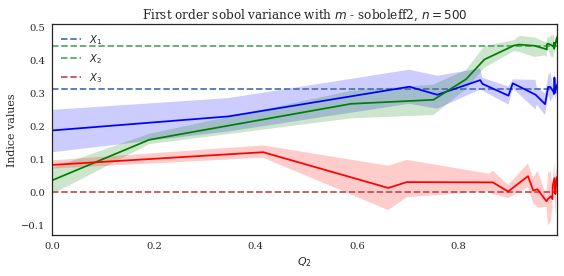

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = ['b', 'g', 'r']
for i in range(dim):
    x = scores_q2[:, i]
    ax.plot([x[0], x[-1]], [model.first_order_sobol_indices[i]]*2, '--')
    sns.tsplot(data=first_indices[:, :, i].T, time=x, ci=95, color=colors[i])
ax.legend(['$X_%d$' % (i+1) for i in range(dim)], loc=0)
ax.set_title('First order sobol variance with $m$ - %s, $n=%d$' % (estimator, n_sample))
ax.set_ylabel('Indice values')
ax.set_xlabel('$Q_2$')
fig.tight_layout()
if savefigs:
    fig.savefig('output/test_first_order_indices_with_m_n_%d.pdf' % (n_sample))

C:\Users\naz-probook\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


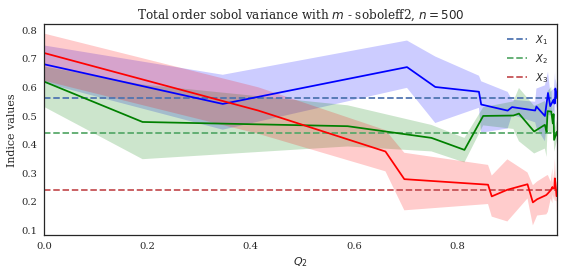

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = ['b', 'g', 'r']
for i in range(dim):
    x = scores_q2[:, i]
    ax.plot([x[0], x[-1]], [model.total_sobol_indices[i]]*2, '--')
    sns.tsplot(data=total_indices[:, :, i].T, time=x, ci=95, color=colors[i])
ax.legend(['$X_%d$' % (i+1) for i in range(dim)], loc=0)
ax.set_title('Total order sobol variance with $m$ - %s, $n=%d$' % (estimator, n_sample))
ax.set_ylabel('Indice values')
ax.set_xlabel('$Q_2$')
fig.tight_layout()
if savefigs:
    fig.savefig('output/test_total_order_indices_with_m_n_%d.pdf' % (n_sample))

C:\Users\naz-probook\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


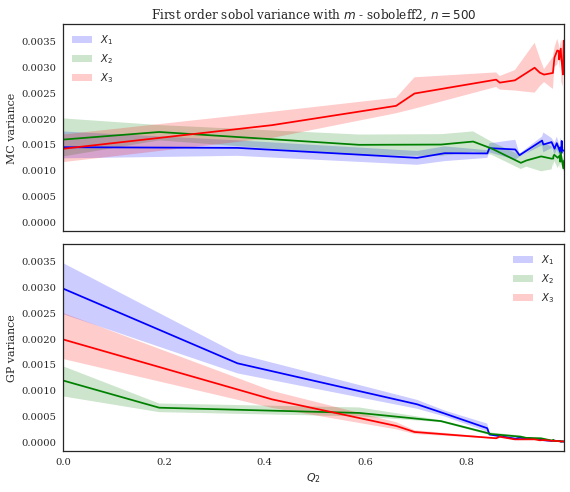

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharey=True, sharex=True)
colors = ['b', 'g', 'r']
for i in range(dim):
    ax = axes[0]
    sns.tsplot(data=var_gp_first_indices[:, :, i].T, time=scores_q2[:, i], ci=95, color=colors[i], ax=ax)
    
    ax = axes[1]
    sns.tsplot(data=var_mc_first_indices[:, :, i].T, time=scores_q2[:, i], ci=95, color=colors[i], ax=ax)
    
ax = axes[0]
ax.legend(['$X_%d$' % (i+1) for i in range(dim)], loc=0)
ax.set_ylabel('MC variance')
ax.set_title('First order sobol variance with $m$ - %s, $n=%d$' % (estimator, n_sample))

ax = axes[1]
ax.legend(['$X_%d$' % (i+1) for i in range(dim)], loc=0)
ax.set_ylabel('GP variance')
ax.set_xlabel('$Q_2$')
fig.tight_layout()
if savefigs:
    fig.savefig('output/test_first_order_variances_with_m_n_%d.pdf' % (n_sample))

C:\Users\naz-probook\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


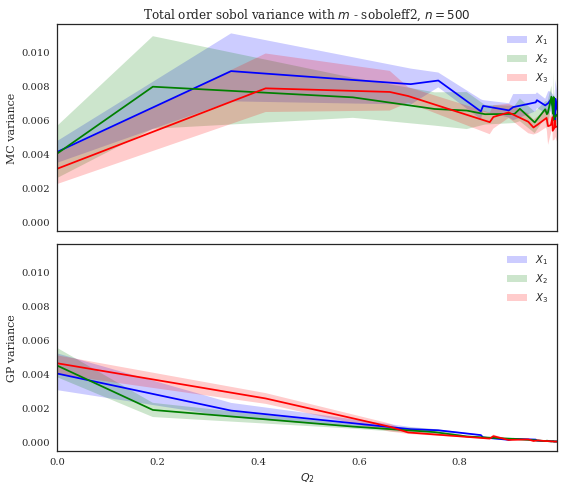

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharey=True, sharex=True)
colors = ['b', 'g', 'r']
for i in range(dim):
    ax = axes[0]
    sns.tsplot(data=var_gp_total_indices[:, :, i].T, time=scores_q2[:, i], ci=95, color=colors[i], ax=ax)
    
    ax = axes[1]
    sns.tsplot(data=var_mc_total_indices[:, :, i].T, time=scores_q2[:, i], ci=95, color=colors[i], ax=ax)
    
ax = axes[0]
ax.legend(['$X_%d$' % (i+1) for i in range(dim)], loc=0)
ax.set_ylabel('MC variance')
ax.set_title('Total order sobol variance with $m$ - %s, $n=%d$' % (estimator, n_sample))

ax = axes[1]
ax.legend(['$X_%d$' % (i+1) for i in range(dim)], loc=0)
ax.set_ylabel('GP variance')
ax.set_xlabel('$Q_2$')
fig.tight_layout()
if savefigs:
    fig.savefig('output/test_total_order_variances_with_m_n_%d.pdf' % (n_sample))